In [1]:
# Run for GPU/CUDA ML, comment out if you dont have it configured.
import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [2]:
from numpy import mean
from numpy import std
import numpy as np
from numpy import dstack
import keras.backend as kb
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

## 7 gestures, windowsize = 50, overlap = 25
dir_list = ["ready_data/x_train.txt", "ready_data/y_train.txt", "ready_data/x_test.txt", "ready_data/y_test.txt"]

## 5 gestures, windowsize = 50, overlap = 25
window_50_25 = ["ready_data/window-50-25/x_train.txt", "ready_data/window-50-25/y_train.txt",
                 "ready_data/window-50-25/x_test.txt", "ready_data/window-50-25/y_test.txt"]

## 5 gestures, windowsize = 50, overlap = 0
no_overlap_50 = ["ready_data/no-overlap-50/x_train.txt", "ready_data/no-overlap-50/y_train.txt",
                  "ready_data/no-overlap-50/x_test.txt", "ready_data/no-overlap-50/y_test.txt"]

## 5 gestures, windowsize = 100, overlap = 0
no_overlap_100 = ["ready_data/no-overlap-100/x_train.txt", "ready_data/no-overlap-100/y_train.txt",
                 "ready_data/no-overlap-100/x_test.txt", "ready_data/no-overlap-100/y_test.txt"]

## 5 gestures, windowsize = 100, overlap = 25
window_100_25 = ["ready_data/window-100-25/x_train.txt", "ready_data/window-100-25/y_train.txt",
                 "ready_data/window-100-25/x_test.txt", "ready_data/window-100-25/y_test.txt"]

## 5 gestures, windowsize = 100, overlap = 50
window_100_50 = ["ready_data/window-100-50/x_train.txt", "ready_data/window-100-50/y_train.txt",
                 "ready_data/window-100-50/x_test.txt", "ready_data/window-100-50/y_test.txt"]

## 5 gestures, windowsize = 100, overlap = 50


num_gestures = 5
overlap = 50
window = 100
data_columns = 6
model_name = 'lstm_models/lstm_model_test_' + str(window) + '_' + str(overlap)


if num_gestures == 7:
    directory = dir_list

elif num_gestures == 5:

    if overlap == 0 and window == 50:
        directory = no_overlap_50

    elif overlap == 25 and window == 50:
        directory = window_50_25

    elif overlap == 0 and window == 100:
        directory = no_overlap_100

    elif overlap == 25 and window == 100:
        directory = window_100_25

    elif overlap == 50 and window == 100:
        directory = window_100_50


## Load data previously saved as numpy text and reshape it to orginal form
loaded_arr = np.loadtxt(directory[0])
x_train = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // data_columns, data_columns)

loaded_arr1 = np.loadtxt(directory[1])
y_train = loaded_arr1

loaded_arr2 = np.loadtxt(directory[2])
x_test = loaded_arr2.reshape(loaded_arr2.shape[0], loaded_arr2.shape[1] // data_columns, data_columns)

loaded_arr3 = np.loadtxt(directory[3])
y_test = loaded_arr3

print('##Before reshaping')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

y_train = to_categorical(y_train, num_classes = num_gestures)
y_test = to_categorical(y_test, num_classes = num_gestures)

print('##After reshaping')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

##Before reshaping
(19090, 100, 6)
(19090,)
(8185, 100, 6)
(8185,)
##After reshaping
(19090, 100, 6)
(19090, 5)
(8185, 100, 6)
(8185, 5)


In [3]:
print(y_test[0])

[1. 0. 0. 0. 0.]


In [4]:
def visualise(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



In [5]:
def evaluate_lstm(x_train, y_train, x_test, y_test, dropout):
    print("start evaluation!")
    LR = 0.0001
    verbose, epochs, batch_size = 1, 20, 64
    # timesteps = window size, #n_features = 6, n_outputs =
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps, n_features), dropout=dropout))
    # model.add(LSTM(100, return_sequences=True, input_shape=(n_timesteps, n_features), dropout=dropout))
    # model.add(LSTM(10, return_sequences=True))
    # model.add(LSTM(64, return_sequences=True))
    # model.add(LSTM(32, return_sequences=True))
    # model.add(LSTM(100, dropout=dropout))
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.3))
    # model.add(Dense(25, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    opt = Adam(lr=LR)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])
    # kb.set_value(model.optimizer.learning_rate, LR)
    # fit network
    model.summary()
    # tf.keras.metrics.CategoricalAccuracy()
    # model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                        validation_data=(x_test, y_test),  shuffle=True)

    ##plot
    visualise(history)
    
    # save model
    if not os.path.exists('lstm_models'):
        os.makedirs('lstm_models')
    model.save(model_name)
    # evaluate model
    _, accuracy, cat_acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=verbose)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

start evaluation!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 53,405
Trainable params: 53,405
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
299/299 [==============================] - 4s 13ms/step - loss: 1.3555 - accuracy: 0.4539 - categorical_accuracy: 0.4539 - val_loss: 1.0913 - val_accuracy: 0.5800 - val_categorical_accuracy: 0.5800
Epoch 2/20
299/299 [===

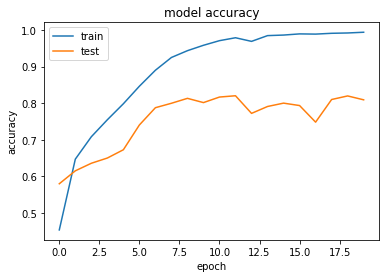

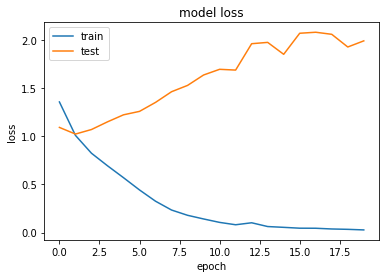

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_models/lstm_model_test_100_50\assets
128/128 [==============================] - 1s 5ms/step - loss: 1.9893 - accuracy: 0.8092 - categorical_accuracy: 0.8092
>#1: 80.916
[80.91630935668945]
Accuracy: 80.916% (+/-0.000)


In [6]:
# run an experiment
def run_experiment(repeats=1):
    # repeat experiment
    dropout = 0.2
    # dropout = [0.0, 0.2, 0.3, 0.4, 0.5]
    scores = list()
    for r in range(repeats):
        ## use basic lstm
        score = evaluate_lstm(x_train, y_train, x_test, y_test, dropout)
        ##use ConvLSTM
        # score = evaluate_convlstm(x_train, y_train, x_test, y_test, dropout)
        score = score * 100.0
        print('>#%d: %.3f' % (r + 1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)


# run the experiment
run_experiment()


## Testing the model

In [7]:
from keras.models import load_model

model = load_model(model_name)

In [8]:
y_pred = model.predict(x_test)

In [9]:
rounded = np.round(y_pred)

print(y_pred[0])
print(rounded[0])
print(y_test[0])

[9.9871886e-01 1.4018622e-04 3.2626492e-06 3.7953295e-04 7.5824041e-04]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]


In [10]:
if num_gestures == 5:
    class_names = ["Buddha clap", "Crank", "Knob", "Pushback", "Swipe"]
elif num_gestures == 7:
    class_names = ["Buddha clap", "Crank left", "Crank right", "Knob left", "Knob right", "Pushback", "Swipe"]

name = np.array(class_names)
print(name)
print(type(name))

['Buddha clap' 'Crank' 'Knob' 'Pushback' 'Swipe']
<class 'numpy.ndarray'>


In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(name.reshape(-1, 1))
# y_pred = enc.transform(y_pred)
y_pred = enc.inverse_transform(rounded)
y_test_label = enc.inverse_transform(y_test)

In [12]:
print(y_pred)
print(y_test_label)

[['Buddha clap']
 ['Buddha clap']
 ['Buddha clap']
 ...
 ['Swipe']
 ['Swipe']
 ['Swipe']]
[['Buddha clap']
 ['Buddha clap']
 ['Buddha clap']
 ...
 ['Swipe']
 ['Swipe']
 ['Swipe']]


In [13]:
output = []

for i in range(len(y_pred)):
    if y_test_label[i] != y_pred[i]:
        output.append([y_test_label[i], y_pred[i]])
        print("Actual: %s, Prediction: %s" % (y_test_label[i], y_pred[i]))

Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Pushback']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['Buddha clap'], Prediction: ['Swipe']
Actual: ['

In [14]:
import csv
from datetime import datetime

fields = ['Actual', 'Predicted']
now = datetime.now()
file = 'output ' + now.strftime("%d-%m-%Y %H-%M-%S") + '.csv'
with open(file, 'w', newline='') as filename:
    write = csv.writer(filename)
    write.writerow(fields)
    write.writerows(output)
